# Setup

In [41]:
# %pip install dill
# %pip install pyreadr
# %pip install scikit-learn
# %pip install pandas
# %pip install numpy
# %pip install xgboost
# %pip install -U matplotlib
# %pip install -U seaborn
# %pip install typeguard
# %pip install PyQt6
# %pip install smogn
# %pip install seaborn
# %pip install -U imbalanced-learn

In [42]:
# library to check function types of imported modules
from typeguard import install_import_hook

# custom functions for plotting, etc.
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo
with install_import_hook('ml_data_objects'):
    import ml_data_objects as mdo

# data import and export
import pyreadr
import dill

# data management libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import percentileofscore

# plots
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# misc
import os

# preprocessing
from smogn import smoter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# k-fold cross-validation
from sklearn.model_selection import KFold

# global parameters
RANDOM_STATE = 42
TOP_THRESHOLD_QUANTILE = 0.8 # values to test: 0.5, 0.6, 0.7, 0.8, 0.9
SMOGN_PREPROCESS = True
UNDERSAMPLE = True


## Setup Plotting Functions

In [43]:

def plot_shaded_scatter_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, pearson_grid: np.ndarray, plot_title: str) -> plt.Figure:
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/11/30
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.create_scatter_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, plot_title)

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, pearson_grid, label="Pearson Coefficient")
    cmp.add_best_fit(axs)

    return fig

In [44]:

def plot_shaded_roc_grids(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, f1_grid: np.ndarray, plot_title: str) -> plt.Figure:
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/12/22
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.create_roc_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, plot_title)

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, f1_grid, label="f1 Score")
    
    return fig

In [45]:
B_average_metrics = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
R_average_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])
RO_average_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

# Add linear regression model metrics from research paper
B_average_metrics.loc['GBLUP'] =  [0.411, 0.696, 0.577, 0.180]
R_average_metrics.loc['GBLUP'] =  [None, 0.215, 0.128, 0.987, 0.164]
RO_average_metrics.loc['GBLUP'] = [None, 0.487, 0.711, 0.699, 0.304]

In [46]:
def plot_GY_hist(GY_df: pd.DataFrame, title: str, x_ax_label: str = 'Grain Yield (GY)', y_ax_label: str = 'Frequency') -> None:
    """
    Create a histogram of grain yield values
    Created: 2024/01/12

    Args:
        GY_df (pd.DataFrame): DataFrame containing grain yield values
        title (str): Title of the plot
    """
    # Create histogram
    plt.hist(GY_df, bins=60, edgecolor='black')

    # Add labels and title
    plt.xlabel(x_ax_label)
    plt.ylabel(y_ax_label)
    plt.title(title)
    plt.savefig(f'{storage_dir}\\{title}.svg', format="svg")
    plt.show()
    plt.close()



## Import Data

In [47]:
def create_numbered_subdir():
    """
    Creates a new subdirectory within the 'saved_data_and_plots' directory, 
    with a name that is the next available number in sequence, formatted as a 
    three-digit number (e.g., '001', '002', etc.).
    Created: 2024/01/01
    Returns:
        str: The path to the newly created numbered subdirectory.
    """
    # Create parent directory if it doesn't exist
    parent_dir = "saved_data_and_plots"
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    
    # Find next available number
    existing_dirs = [d for d in os.listdir(parent_dir) 
                    if os.path.isdir(os.path.join(parent_dir, d))]
    existing_nums = [int(d) for d in existing_dirs if d.isdigit()]
    next_num = max(existing_nums + [-1]) + 1
    
    # Create new numbered directory
    new_dir = os.path.join(parent_dir, f"{next_num:03d}")
    os.makedirs(new_dir)
    return new_dir

storage_dir = create_numbered_subdir()

,GY
GID,
GID6569128,6.119272
GID6569128,5.905515
GID6569128,2.160587
GID6569128,6.456711
GID6688880,3.616688


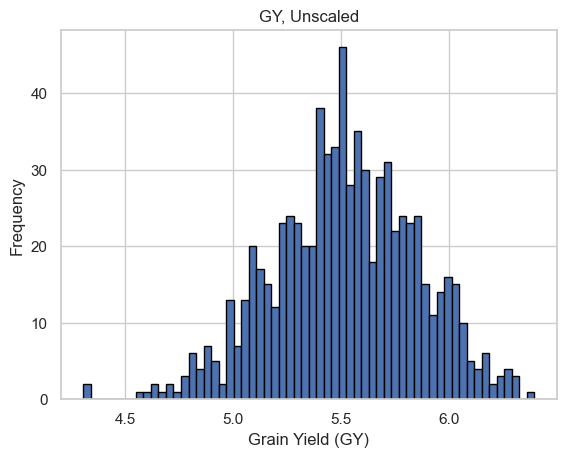

,GY
count,766.000000
mean,5.517416
std,0.333979
min,4.305651
25%,5.301989
50%,5.517454
75%,5.748336
max,6.394285


In [48]:
# import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# extract training example labels
y = eyt1['Pheno_Disc_Env1'][['GY']]

y = y.set_index(eyt1['Pheno_Disc_Env1']['GID'])

y = y.sort_index()

display(y.head())

# check missing values
cdt.assert_no_bad_values(y)

# each seed was planted in 4 different environments, but we don't care about environmental differences
# so we take the average of every group of four rows to reduce the dataset to 1/4 its original size
y = cdt.avg_rows(y, 4)

plot_GY_hist(y, 'GY, Unscaled')
y.describe()


In [49]:
# extract feature matrix and set index to match y
X = eyt1['Geno_Env1'].sort_index()

display(X)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

"""
# temporary data override for quick testing
y_bin = pd.DataFrame(data={'GY': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]})
X = pd.DataFrame(data={'rs1': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40],})
"""

,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939899,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945
GID6569128,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.125612,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459
GID6688880,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.072171,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447
GID6688916,0.025987,0.064585,1.170073,-0.021636,-0.031717,0.101532,-0.196780,0.041900,-0.013459,0.126464,...,0.428609,0.423184,0.427788,0.408326,0.426844,0.006038,0.209395,0.240468,0.255337,0.163524
GID6688933,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.079312,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800
GID6688934,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.016690,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GID6939917,0.004096,0.104630,0.006038,-0.140529,-0.098509,0.048248,-0.114305,0.062388,0.060255,0.034630,...,0.144931,0.144932,0.155032,0.150037,0.161459,1.112390,0.077593,0.107666,0.121171,0.087428
GID6939919,0.091188,0.113878,0.209395,-0.088961,-0.052304,0.139241,-0.141205,0.184798,0.070163,0.015030,...,0.255040,0.249602,0.262775,0.242206,0.253641,0.077593,0.986131,0.159823,0.380622,0.167608
GID6939938,0.074009,0.108757,0.240468,-0.096740,-0.012778,0.058980,-0.149919,0.000392,0.063573,0.090066,...,0.719743,0.728707,0.732558,0.708062,0.704652,0.107666,0.159823,1.118190,0.388284,0.389739
GID6939941,0.032992,0.154718,0.255337,-0.159136,-0.100318,0.045545,-0.206353,0.194754,0.043889,0.084022,...,0.465269,0.461691,0.473004,0.432339,0.435412,0.121171,0.380622,0.388284,1.070441,0.219306


"\n# temporary data override for quick testing\ny_bin = pd.DataFrame(data={'GY': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]})\nX = pd.DataFrame(data={'rs1': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40],})\n"

In [50]:
def scale_features_and_target(X: pd.DataFrame, y: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler):
    """
    Scale the feature matrix and target values using StandardScaler.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.DataFrame): Target values.
    
    Returns:
        X_sc (pd.DataFrame): Scaled feature matrix.
        y_sc (pd.DataFrame): Scaled target values.
        X_scaler (StandardScaler): Scaler used for features.
        y_scaler (StandardScaler): Scaler used for target.
    """
    X_sc, y_sc, X_scaler, y_scaler = None, None, None, None

    # scale feature matrix

    if X is not None:
        X_scaler = StandardScaler()
        X_sc = X_scaler.fit_transform(X)
        X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

    if y is not None:
        y_scaler = StandardScaler()
        y_sc = y_scaler.fit_transform(y)
        y_sc = pd.DataFrame(y_sc, index=y.index, columns=y.columns)
    
    return X_sc, y_sc, X_scaler, y_scaler

In [51]:
def smogn_prep(X: pd.DataFrame, y: pd.DataFrame, top_threshold_quantile: float, undersample: bool = True) -> None:
    """
    Preprocesses the dataset using the SMOGN algorithm
    Created: 2024/02/05

    Args:
        X (pd.DataFrame): Feature matrix
        GY_df (pd.DataFrame): DataFrame containing grain yield values
        top_threshold_quantile (float): The quantile value to use as the threshold for the top class
    """

    # temporarily combine X and y for compability with smogn library
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    smogn_X_y = pd.concat([X, y], axis=1)

    # get GY distribution points
    gy_min = y['GY'].min()
    gy_max = y['GY'].max()
    gy_just_under_threshold = y['GY'].quantile(top_threshold_quantile - 0.0001)
    gy_just_over_threshold = y['GY'].quantile(top_threshold_quantile + 0.0001)

    ctrl_points = [
        [gy_min, 0, 0],
        [gy_just_under_threshold, 0, 0],
        [gy_just_over_threshold, 1, 0],
        [gy_max, 1, 0]
    ]

    

    display(smogn_X_y)

    n_tries = 0
    done = False
    while not done:
        try:
            X = smoter(
            data=smogn_X_y,
            y='GY',
            k=5,
            under_samp=undersample,
            samp_method='balance',
            rel_thres=top_threshold_quantile,
            rel_method='manual',
            rel_ctrl_pts_rg=ctrl_points,
            rel_xtrm_type='high',
            rel_coef=1.50
        )
            done = True

        except ValueError:
            if n_tries < 5:
                n_tries += 1
            else:
                raise

    # split X and y back into separate DataFrames
    y = X[['GY']]
    X = X.drop(columns=['GY'])

    return X, y

In [52]:
top_boundary_val = y["GY"].quantile(TOP_THRESHOLD_QUANTILE)

# Model R

In [ ]:
def inner_CV_R(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, 
               train_model_callback, kfold_random_state: int, plot_title: str = "", **kwargs):
    """Perform inner cross-validation with grid search to find the best model parameters.
    Created: 2024/12/03
    Parameters:
    -----------
    n_splits : int
        Number of splits for KFold cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Parameter grid for the first axis.
    axis2_params : mdo.AxisParams
        Parameter grid for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for KFold shuffling.
    plot_title : str, optional
        Title for the plot (default is "").
    **kwargs : dict
        Additional keyword arguments for the model training.
    Returns:
    --------
    avg_best_param1 : float
        Average best parameter value for the first axis over all folds.
    avg_best_param2 : float
        Average best parameter value for the second axis over all folds."""

    # Create KFold object for inner-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Store best parameters (C, gamma) for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # print(f"    INNER FOLD {i}")
        
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train numpy 2D array of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # Use trained models to predict test set labels, and store in 2D array with each cell corresponding to a model with specific combination of parameters
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of pearson coefficients
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # Find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # Store hyperparameters of most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]
        # print(f"    Best parameters found: \n{best_params.loc[i]}")

        # Create grid of scatter plots with predictions vs actuals, coloured by pearson coefficient for each model
        scatter_grid = plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, f'{plot_title} | Inner Fold {i}')        
        plt.savefig(f'{storage_dir}\\Model R {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")
        plt.show(scatter_grid)
        plt.close(scatter_grid)

    # calculate average best parameters over all inner folds to return to outer CV
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    return avg_best_param1, avg_best_param2

        

In [ ]:
def outer_CV_R(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, 
               axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, 
               train_model_callback : callable, kfold_random_state: int, top_boundary_val : float,
               smogn_preprocess = False, undersample = True, **kwargs) -> pd.DataFrame:
    """
    Perform nested cross-validation with an outer and inner loop to evaluate model performance.
    Created: 2024/12/03
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation loop.
    n_inner_splits : int
        Number of splits for the inner cross-validation loop.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object containing parameter list for the first hyperparameter axis (horizontal).
    axis2_params : mdo.AxisParams
        Object containing parameter list for the first hyperparameter axis (vertical).
    train_model_callback : callable
        Function to train the model. Should accept X, y, and hyperparameters as arguments.
    kfold_random_state : int
        Random state for reproducibility in KFold splitting.
    top_line_thresh : float
        Threshold to classify predictions as top or not top.
    **kwargs
        Additional arguments to pass to the train_model_callback function.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing 5 metrics (Pearson, F1 Score, Sensitivity, Specificity, Kappa) for each outer fold.
    """
    
    # Create KFold object for outer loop to split data into train and test sets
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    # Store metrics for each fold
    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Create arrays to store outer-fold final "super model"'s predictions and actuals
    super_model_preds = [None] * n_outer_splits
    super_model_actuals = [None] * n_outer_splits 

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # print(f"OUTER CV: {train_model_callback.__name__}, FOLD {i}")

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if smogn_preprocess:
            top_boundary_quantile_in_train_set = percentileofscore(y_train.to_numpy().flatten(), top_boundary_val, kind='mean') / 100
            # print(f'top_boundary_quantile_in_train_set: {top_boundary_quantile_in_train_set}')
            # print(f"X_train shape: {X_train.shape}")
            # print(f"y_train shape: {y_train.shape}")
            # print(f"X_train head: \n{X_train.head()}")
            # print(f"y_train head: \n{y_train.head()}")
            # print(f"y_train summary statistics:")
            # display(y_train.describe())
            X_train_pre_smogn = X_train.copy()
            y_train_pre_smogn = y_train.copy()
            X_train, y_train = smogn_prep(X_train, y_train, top_boundary_quantile_in_train_set, undersample)

            if not undersample:
                # Unfortunately the SMOGN library for some reason only returns augmented data when undersampling is disabled. 
                # This means we need to manually concatenate the original data below the augmentation threshold with the 
                # augmented data. Read more: https://github.com/nickkunz/smogn/issues/21
                non_augmented_indices = y_train_pre_smogn[y_train_pre_smogn < top_boundary_val].index
                X_train_non_augmented = X_train_pre_smogn.loc[non_augmented_indices]
                y_train_non_augmented = y_train_pre_smogn.loc[non_augmented_indices]
                X_train = pd.concat([X_train, X_train_non_augmented], axis=0)
                y_train = pd.concat([y_train, y_train_non_augmented], axis=0)
                
                # print shapes, first few rows of dfs, and stuff for debugging
                # print(f"X_train shape: {X_train.shape}")
                # print(f"y_train shape: {y_train.shape}")
                # print(f"X_train head: \n{X_train.head()}")
                # print(f"y_train head: \n{y_train.head()}")
                # print(f"y_train summary statistics:")
                # display(y_train.describe())

            plot_GY_hist(y_train, f'Model R SMOGN-Augmented GY Histogram, Outer Fold {i}')
        else:
            plot_GY_hist(y_train, f'Model R Histogram, Outer Fold {i}')

        print(f'y_train summary statistics:')
        display(y_train.describe())

        X_train, y_train, X_scaler, y_scaler = scale_features_and_target(X_train, y_train)
        top_boundary_val_scaled = y_scaler.transform([[top_boundary_val]])[0, 0]
        X_test = X_scaler.transform(X_test)
        y_test = y_scaler.transform(y_test)
            
        # Find mean best hyperparameter values based on prediction accuracy using inner-fold CV
        best_param1, best_param2 = inner_CV_R(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)
        # print(f"Average best parameters: {best_param1}, {best_param2}")

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)
        plot_GY_hist(y_pred, f'Model R Predicted GY Histogram, {train_model_callback.__name__}, Outer Fold {i}')

        # Calculate pearson coefficient of continuous predictions
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # Classify predictions and actuals of super_model as top or not top (boolean)
        # print(f"Predictions: \n{y_pred}")
        # print(f"Actuals: \n{y_test}")

        # print("y_pred: ", y_pred)
        y_pred_top = bmo.continuous_to_binary_absolute(y_pred, top_boundary_val_scaled)
        # print(f'y_pred_top: {y_pred_top}')
        super_model_preds[i] = y_pred_top
        y_test_top = bmo.continuous_to_binary_absolute(y_test, top_boundary_val_scaled)
        super_model_actuals[i] = y_test_top

        # print(f"Top Boundary Value (Scaled): \n{top_boundary_val_scaled}")
        print(f"Binary Predictions: \n{y_pred_top}")
        print(f"Binary Actuals: \n{y_test_top}")

        # plot super model predictions vs actuals scatterplot
        cmp.plot_classification_results(y_pred, y_test, y_pred_top, y_test_top, 
                                        [f"Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}"],
                                        save_path=f'{storage_dir}\\Super Model Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}.svg')

        # Calculate classification metrics and add new row to kfold_metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)
        print(classification_metrics)
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)

    # Label each row of kfold_metrics with the fold number 
    kfold_metrics.index = range(n_outer_splits)
    
    return kfold_metrics

## Support Vector Machine

In [ ]:

# Real values 
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_R = outer_CV_R(n_outer_splits=5, 
                           n_inner_splits=10, 
                           X=X, 
                           y=y,
                           axis1_params=x_params_SVM_R, 
                           axis2_params=y_params_SVM_R, 
                           train_model_callback=bmo.train_SVM_regressor, 
                           smogn_preprocess=SMOGN_PREPROCESS,
                           undersample=UNDERSAMPLE,
                           kfold_random_state=RANDOM_STATE, 
                           top_boundary_val=top_boundary_val, 
                           kernel='rbf')

"""
# Dummy values for quick debugging tests  
x_params_SVM_R = mdo.AxisParams('gamma', bmo.power_list(2, -1, 0))  
y_params_SVM_R = mdo.AxisParams('C', bmo.power_list(2, 1, 2))  
metrics_SVM_R = outer_CV_R(n_outer_splits=2,   
                           n_inner_splits=2,   
                           X=X,  
                           y=y,    
                           axis1_params=x_params_SVM_R,   
                           axis2_params=y_params_SVM_R,   
                           train_model_callback=bmo.train_SVM_regressor,   
                           smogn_preprocess=SMOGN_PREPROCESS,  
                           kfold_random_state=RANDOM_STATE,   
                           top_line_thresh=TOP_THRESHOLD_QUANTILE,   
                           kernel='rbf')  
"""  

In [ ]:
# Display classification metrics for best model from each outer fold
display(metrics_SVM_R)

In [ ]:
# Save average of each metric
metrics_SVM_R_mean = metrics_SVM_R.mean().to_frame().T
R_average_metrics.loc['SVM'] = metrics_SVM_R_mean.iloc[0]
display(metrics_SVM_R_mean)

## XGBoost

In [ ]:

# Test values
x_params_XGB_R = mdo.AxisParams('n_estimators', [13, 25, 50, 100, 200])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16])
metrics_XGB_R = outer_CV_R(n_outer_splits=5, 
                           n_inner_splits=10, 
                           X=X, 
                           y=y,  
                           axis1_params=x_params_XGB_R, 
                           axis2_params=y_params_XGB_R, 
                           train_model_callback=bmo.train_XGB_regressor, 
                           smogn_preprocess=SMOGN_PREPROCESS,
                           undersample=UNDERSAMPLE,
                           kfold_random_state=RANDOM_STATE, 
                           top_boundary_val=top_boundary_val, 
                           objective="reg:squarederror", eval_metric="rmse")

"""
# Dummy values for quick debugging tests
x_params_XGB_R = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_R = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_R = outer_CV_R(2, 2,  X_sc, y_sc, X_smogn, y_smogn, x_params_XGB_R, y_params_XGB_R, bmo.train_XGB_regressor, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, objective="reg:squarederror", eval_metric="rmse", top_line_thresh=TOP_THRESHOLD_QUANTILE)
"""

In [ ]:
# Display classification metrics for best model from each outer fold
display(metrics_XGB_R)

In [ ]:
# Print average of each metric and store results for analysis
metrics_XGB_R_mean = metrics_XGB_R.mean().to_frame().T
display(metrics_XGB_R_mean)
R_average_metrics.loc['XGB'] = metrics_XGB_R_mean.iloc[0]

In [ ]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_R.db')

# Model B

In [53]:
def inner_CV_B(n_splits: int, X : pd.DataFrame, y_bin : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, 
               train_model_callback, kfold_random_state: int, classification_col : int, plot_title: str = "", 
               **kwargs):
    """
    Perform inner cross-validation to tune model hyperparameters and find the optimal classification threshold.
    Created: 2024/12/04
    Parameters:
    n_splits (int): Number of splits for KFold cross-validation.
    X (pd.DataFrame): Feature data.
    y (pd.DataFrame): Target data.
    axis1_params (mdo.AxisParams): Object containing hyperparameter values for the first (horizontal) axis.
    axis2_params (mdo.AxisParams): Object containing hyperparameter values for the second (vertical) axis.
    train_model_callback (function): Callback function to train the model.
    kfold_random_state (int): Random state for KFold shuffling.
    classification_col (int): Column index to pull classification proabibilities from - 0 for not top, 1 for top.
    top_thresh_quantile (float): Threshold to classify predictions as top or not top.
    plot_title (str, optional): Title for the ROC plot. Defaults to "".
    **kwargs: Additional arguments for the train_model_callback function.
    Returns:
    tuple: Average best parameters (param1, param2) and the best classification threshold.
    """
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Arrays to store parameters and binary classification thresholds of most accurate model for each inner fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"    INNER FOLD {i}")
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_bin_train, y_bin_test = y_bin.iloc[train_index], y_bin.iloc[test_index]

        print('X train:')
        print(X_train)

        print('y_train_bin:')
        print(y_bin_train)

        
        # Train numpy 2D array of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_bin_train, axis1_params, axis2_params, train_model_callback, **kwargs)
        
        # Use trained models to predict test set probabilities, and store in 2D array with each cell corresponding to a model with specific combination of parameters
        y_proba_preds_grid = bmo.grid_predict_proba(X_test, model_grid, classification_col)

        # Use probabilities to classify predictions as top or not top. This isn't the final classification, 
        # but a step towards finding the optimal threshold, so we just use the default 0.5 threshold for now.
        y_binary_preds_grid = bmo.continuous_to_binary_absolute_grid(y_proba_preds_grid, 0.5)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_bin_test_grid = cdt.np_array_of_dfs(y_bin_test, y_proba_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of f1 scores.
        f1_grid = bmo.calculate_f1_scores(y_binary_preds_grid, y_bin_test_grid)

        # Find index of best f1 score in the 2d array of f1 scores
        best_row, best_col = np.unravel_index(np.argmax(f1_grid), f1_grid.shape)
        print("     Best row, best col: \n", best_row, best_col)
        print("     Inner CV Probability Predictions at best row, best col: \n", y_proba_preds_grid[best_row, best_col])
        print("     Inner CV binary predictions at best row, best col: \n", y_binary_preds_grid[best_row, best_col])
        print("     Inner CV actuals at best row, best col: \n", y_bin_test_grid[best_row, best_col])
        print("     Inner CV f1 score at best row, best col: \n", f1_grid[best_row, best_col])

        # Store hyperparameters of most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]
        print(f"    Best parameters found: \n{best_params.loc[i]}")

        # Find classification probability threshold between zero and one that yields lowest squared difference between sensitivity and 
        # specificity using this optimal model. To do this, we feed find_optimal_threshold() the probabilities predicted by the model, not the binary predictions.
        best_model_proba_preds = y_proba_preds_grid[best_row, best_col]
        best_thresholds.iloc[i, 0] = bmo.find_optimal_threshold_absolute(y_bin_test, best_model_proba_preds)
        print(f"    Best probability threshold found: {best_thresholds.iloc[i, 0]}")

        # Create grid of ROC plots with predictions vs actuals, coloured by f1 score for each model
        roc_grid = plot_shaded_roc_grids(y_proba_preds_grid, y_bin_test_grid, axis1_params, axis2_params, f1_grid, f'{plot_title} | Inner Fold {i}')        
        plt.savefig(f'{storage_dir}\\model_B, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")

        plt.show(roc_grid)
        plt.close(roc_grid)

    # Calculate average best parameters over all inner folds to return to outer CV
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # Calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [ ]:
def outer_CV_B(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, 
               axis1_params: mdo.AxisParams, 
               axis2_params: mdo.AxisParams, train_model_callback : callable, random_state: int, 
               classification_col : int, top_boundary_val : float, smote_preprocess = False, **kwargs) -> pd.DataFrame:
    """
    Perform nested cross-validation with an outer and inner loop to evaluate model B performance.
    Created: 2024/12/29
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation.
    n_inner_splits : int
        Number of splits for the inner cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object representing hyperparameter search space for the first axis.
    axis2_params : mdo.AxisParams
        Object representing hyperparameter search space for the second axis.
    train_model_callback : callable
        Function to train the model.
    kfold_random_state : int
        Random state for reproducibility in KFold.
    classification_col : int
        Column index to pull classification probabilities from - 0 for not top, 1 for top.
    top_line_thresh : float
        Threshold to classify predictions as top or not top.
    **kwargs : dict
        Additional parameters for the model training function.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the metrics for each outer fold, including F1 Score, Sensitivity, Specificity, and Kappa.
    """
    
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=random_state)


    # Store metrics of best model for each fold
    kfold_metrics = pd.DataFrame(columns=['F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"OUTER CV: {train_model_callback.__name__}, FOLD {i}")

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        y_train_bin = bmo.continuous_to_binary_absolute(y_train, top_boundary_val)
        y_test_bin = bmo.continuous_to_binary_absolute(y_test, top_boundary_val)

        # Print shape of data and number of top and not top samples
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"Number of top samples in y_train: {y_train_bin.sum()}")
        
        if smote_preprocess:
            sm = SMOTE(random_state=random_state)
            X_train, y_train_bin = sm.fit_resample(X_train, y_train_bin)
            print(f"X_train shape after SMOTE: {X_train.shape}")	
            print(f"y_train shape after SMOTE: {y_train_bin.shape}")
            print(f"Number of top samples in y_train after SMOTE: {y_train_bin.sum()}")
            
        X_train, _, X_scaler, _ = scale_features_and_target(X_train, None)
        X_test = X_scaler.transform(X_test)

        # Find average best parameters and threshold based on f1 score using inner-fold CV
        best_param1, best_param2, best_threshold = inner_CV_B(n_inner_splits, X_train, y_train_bin, axis1_params, axis2_params, train_model_callback, random_state, classification_col, plot_title=f"Outer Fold {i}", **kwargs)

        print(f"Average best parameters: {best_param1}, {best_param2}")
        print(f"Average best threshold: {best_threshold}")

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train_bin), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set probabilities
        y_pred_proba = pd.DataFrame(super_model.predict_proba(X_test)[:, classification_col], index=y_test_bin.index, columns=y_test_bin.columns)
        plot_GY_hist(y_pred_proba, f'Top Line Probability Histogram, {train_model_callback.__name__}, Outer Fold {i}', x_ax_label='Top Line Probability')

        # Classify predictions and actuals of super_model as top or not top (boolean) using the best threshold as determined by inner CV
        y_pred_bin = bmo.continuous_to_binary_absolute(y_pred_proba, best_threshold)
        print(f"Probability Predictions: \n{y_pred_proba}")
        print(f"Binary Predictions: \n{y_pred_bin}")
        print(f"Actuals: \n{y_test_bin}")

        # Plot ROC and PR curves using seaborn
        cmp.sns_plot_roc_curve(pd.DataFrame(y_test_bin), pd.DataFrame(y_pred_proba), f'Model B ROC Curve, {train_model_callback.__name__}, Outer Fold {i}')
        plt.savefig(f'{storage_dir}\\Model B ROC Curve, {train_model_callback.__name__}, Outer Fold {i}.svg', format="svg")
        plt.show()
        plt.close()

        cmp.sns_plot_pr_curve(pd.DataFrame(y_test_bin), pd.DataFrame(y_pred_proba), f'Model B PR Curve, {train_model_callback.__name__}, Outer Fold {i}')
        plt.savefig(f'{storage_dir}\\Model B PR Curve, {train_model_callback.__name__}, Outer Fold {i}.svg', format="svg")
        plt.show()
        plt.close()
    
        # Calculate classification metrics and add new row to kfold_metrics   
        classification_metrics = cdt.classification_metrics(y_pred_bin, y_test_bin)   
        kfold_metrics = pd.concat([kfold_metrics, classification_metrics], axis=0)   

    # Label each row of kfold_metrics with the fold number
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

## SVM

In [55]:

# Real test values
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -18, -8))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 2, 16))
metrics_SVM_B = outer_CV_B(5, 10, X, y, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, 
                           random_state=RANDOM_STATE, classification_col=1, top_boundary_val=top_boundary_val, 
                           smote_preprocess=False, probability=True, kernel='rbf')

"""
# Dummy values for tests
x_params_SVM_B = mdo.AxisParams('gamma', bmo.power_list(2, -10, -9))
y_params_SVM_B = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM_B = outer_CV_B(2, 2, X, y, x_params_SVM_B, y_params_SVM_B, bmo.train_SVM_classifier, kfold_random_state=RANDOM_STATE, kernel='rbf', classification_col=1, top_boundary_val=top_boundary_val, probability=True)
"""

OUTER CV: train_SVM_classifier, FOLD 0
    INNER FOLD 0
X train:
     GID6569128  GID6688880  GID6688916  GID6688933  GID6688934  GID6688949  \
0      6.043384   -0.153116   -0.122532   -0.699104   -0.653973    0.916929   
1     -0.469112    9.853762    0.118903   -0.907374   -0.172494    0.676751   
4     -1.709276   -0.909105   -0.483473    3.347600    6.577269   -2.368683   
5      0.371567    0.712057    0.350003   -0.294516   -0.546787   12.643571   
6     -1.324536   -2.129209   -1.515949    3.061372    2.814146   -1.308138   
..          ...         ...         ...         ...         ...         ...   
757    0.679440    0.537269    2.361952   -0.344987    0.226043    0.895713   
758    0.709315    0.499227    2.390749   -0.359492    0.169695    0.881762   
763    0.189733    1.014877    1.219057   -0.406926    0.254841    0.400715   
764   -0.146169    1.480871    1.312059   -0.840420   -0.293449    0.214441   
765    1.217080   -0.042709    0.737770   -0.490716   -0.633165   

KeyboardInterrupt: 

In [ ]:
# Display classification metrics for super-model trained on all data from each outer fold
display(metrics_SVM_B)

In [ ]:
# Print average of each metric
metrics_SVM_B_mean = metrics_SVM_B.mean().to_frame().T
B_average_metrics.loc['SVM'] = metrics_SVM_B_mean.iloc[0]
display(metrics_SVM_B_mean)

## XGBoost

In [ ]:
# Real test values
x_params_XGB_B = mdo.AxisParams('n_estimators', [3, 7, 13, 25, 50, 100, 200, 400])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16, 32, 64])
metrics_XGB_B = outer_CV_B(5, 10, X, y, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, random_state=RANDOM_STATE, 
                           random_state=RANDOM_STATE, classification_col=1, top_boundary_val=top_boundary_val, smote_preprocess=SMOGN_PREPROCESS, 
                           objective="binary:logistic", eval_metric="logloss")

"""
# dummy values for quick tests
x_params_XGB_B = mdo.AxisParams('n_estimators', [1, 2])
y_params_XGB_B = mdo.AxisParams('max_depth', [1, 2])
metrics_XGB_B = outer_CV_B(2, 2, X, y, x_params_XGB_B, y_params_XGB_B, bmo.train_XGB_classifier, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, classification_col=1, top_boundary_val=top_boundary_val, objective="binary:logistic", eval_metric="logloss")
"""

In [ ]:
# display metrics
display(metrics_XGB_B)"

In [ ]:
# Print average of each metric
metrics_XGB_B_mean = metrics_XGB_B.mean().to_frame().T
B_average_metrics.loc['XGB'] = metrics_XGB_B_mean.iloc[0]
display(metrics_XGB_B_mean)

In [ ]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_B.db')

# Model RO

In [ ]:
def inner_CV_RO(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, y_top_bound : float, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, 
                kfold_random_state: int, plot_title: str = "", **kwargs):
    
    """
    Perform inner cross-validation (RO) to find the best model parameters and classification threshold.
    Created: 2024/12/21
    Parameters:
    n_splits (int): Number of splits for K-Fold cross-validation.
    X (pd.DataFrame): Feature data.
    y (pd.DataFrame): Target data.
    axis1_params (mdo.AxisParams): Hyperparameters to explore for the horizontal axis.
    axis2_params (mdo.AxisParams): Hyperparameters to explore for the vertical axis.
    train_model_callback (callable): Callback function to train the model.
    kfold_random_state (int): Random state for K-Fold shuffling.
    top_line_threshold (float): Threshold to classify top values during intermediate step in inner CV.
    plot_title (str, optional): Title for the plot. Defaults to "".
    **kwargs: Additional keyword arguments for the model training callback.
    Returns:
    tuple: Average best parameters for axis1 and axis2, and the best classification threshold.
    """

    # Create KFold object for inner-fold cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # Store best parameters (param1, param2) for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"    INNER FOLD {i}")
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train numpy 2D array of models with every combination of parameters
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # Use trained models to predict test set labels, and store in 2D array with each cell corresponding to a model with specific combination of parameters
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # Create 2D array of identical dataframes containing actual labels to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # Evaluate predictions by comparing to actuals, calculating 2D array of pearson coefficients
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # Find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # Store hyperparameters of most accurate model for this inner fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]
        print(f"    Best parameters found: \n{best_params.loc[i]}")

        # Extract best model's continuous predictions
        best_model_y_preds = y_preds_grid[best_row, best_col]

        # Classify labels as top or not top (boolean)
        y_test_binary = bmo.continuous_to_binary_absolute(y_test, y_top_bound)
        print(f"    Predictions: \n{best_model_y_preds}")
        print(f"    Actuals: \n{y_test}")
        print(f"    Top Boundary Value (Calculated from Actuals): {y_top_bound}")
        print(f"    Binary Actuals: \n{y_test_binary}")
        
        # Find classification threshold that yields lowest squared difference between sensitivity and specificity using this optimal model
        best_absolute_thresh = bmo.find_optimal_threshold_absolute(y_test_binary, best_model_y_preds)
        best_thresholds.iloc[i, 0] = best_absolute_thresh
        print(f"    Best threshold found: {best_absolute_thresh}")

        # Create grid of scatter plots with predictions vs actuals, coloured by pearson coefficient for each model
        scatter_grid = plot_shaded_scatter_grids(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, f'{plot_title} | Inner Fold {i}')        
        plt.savefig(f'{storage_dir}\\model_RO, {train_model_callback.__name__}, ({plot_title}, Inner Fold {i}).svg', format="svg")
        plt.show(scatter_grid)
        plt.close(scatter_grid)

    # Calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # Calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [ ]:
def outer_CV_RO(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, 
                axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback : callable, 
                kfold_random_state: int, top_boundary_val : float, smogn_preprocess : bool = False, undersample : bool = True,
                **kwargs) -> pd.DataFrame:
    """
    Perform outer cross-validation with nested inner cross-validation for model RO selection and evaluation.
    Parameters:
    -----------
    n_outer_splits : int
        Number of splits for the outer cross-validation.
    n_inner_splits : int
        Number of splits for the inner cross-validation.
    X : pd.DataFrame
        Feature data.
    y : pd.DataFrame
        Target data.
    axis1_params : mdo.AxisParams
        Object representing hyperparameter search space for the first axis.
    axis2_params : mdo.AxisParams
        Object representing hyperparameter search space for the second axis.
    train_model_callback : callable
        Callback function to train the model.
    kfold_random_state : int
        Random state for reproducibility in KFold splitting.
    top_line_threshold : float
        Threshold for classifying top predictions during intermediate step in inner CV.
    **kwargs : dict
        Additional parameters for the model training callback.
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the evaluation metrics for each outer fold, including Pearson correlation, F1 Score, Sensitivity, Specificity, and Kappa.
    """

    # Create KFold object for outer loop to split data into train and test sets
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        print(f"OUTER CV: {train_model_callback.__name__}, FOLD {i}")

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if smogn_preprocess:
            top_boundary_quantile_in_train_set = percentileofscore(y_train.to_numpy().flatten(), top_boundary_val, kind='mean') / 100

            X_train_pre_smogn = X_train.copy()
            y_train_pre_smogn = y_train.copy()
            X_train, y_train = smogn_prep(X_train, y_train, top_boundary_quantile_in_train_set, undersample)

            if not undersample:
                # Unfortunately the SMOGN library for some reason only returns augmented data when undersampling is disabled. 
                # This means we need to manually concatenate the original data below the augmentation threshold with the 
                # augmented data. Read more: https://github.com/nickkunz/smogn/issues/21
                non_augmented_indices = y_train_pre_smogn[y_train_pre_smogn < top_boundary_val].index
                X_train_non_augmented = X_train_pre_smogn.loc[non_augmented_indices]
                y_train_non_augmented = y_train_pre_smogn.loc[non_augmented_indices]
                X_train = pd.concat([X_train, X_train_non_augmented], axis=0)
                y_train = pd.concat([y_train, y_train_non_augmented], axis=0)
            plot_GY_hist(y_train, f'Model RO SMOGN-Augmented GY Histogram, Outer Fold {i}')

        X_train, y_train, X_scaler, y_scaler = scale_features_and_target(X_train, y_train)
        top_boundary_val_scaled = y_scaler.transform([[top_boundary_val]])[0, 0]
        X_test = X_scaler.transform(X_test)
        y_test = y_scaler.transform(y_test)

        # Find average best parameters and threshold based on pearson score using inner-fold CV
        best_param1, best_param2, best_threshold_fixed = inner_CV_RO(n_inner_splits, X_train, y_train, top_boundary_val_scaled, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)
        print(f"Average best parameters: {best_param1}, {best_param2}")
        print(f"Average best threshold: {best_threshold_fixed}")

        # Train model with all training and CV data of outer fold using mean best hyperparameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # Use trained "super-model" to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)
        plot_GY_hist(y_pred, f'Predicted GY Histogram, {train_model_callback.__name__}, Outer Fold {i}')
        print(f"Super model predictions: \n{y_pred}")

        # Calculate pearson coefficient of continuous predictions
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # Classify predictions and actuals of super_model as top or not top (boolean)
        y_pred_top = bmo.continuous_to_binary_absolute(y_pred, best_threshold_fixed)
        y_test_top = bmo.continuous_to_binary_absolute(y_test, top_boundary_val_scaled)

        print(y_test_top)

        cmp.plot_classification_results(y_pred, y_test, y_pred_top, y_test_top, 
                                [f"Model RO Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}"],
                                save_path=f'{storage_dir}\\Model RO Super Model Predicted vs Actual GY, {train_model_callback.__name__}, Outer Fold {i}.svg')

        # Calculate classification metrics and add new row to kfold_metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

## SVM

In [ ]:

# Real values
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -14, -6))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, -2, 6))
metrics_SVM_RO = outer_CV_RO(5, 10, X, y, x_params_SVM_RO, y_params_SVM_RO, bmo.train_SVM_regressor, 
                             kfold_random_state=RANDOM_STATE, top_boundary_val=top_boundary_val, smogn_preprocess=SMOGN_PREPROCESS, 
                             undersample=UNDERSAMPLE, kernel='rbf')

"""# Quick test values
x_params_SVM_RO = mdo.AxisParams('gamma', bmo.power_list(2, -8, -7))
y_params_SVM_RO = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
"""


In [ ]:
# display metrics
display(metrics_SVM_RO)

In [ ]:
# Print average of each metric
metrics_SVM_RO_mean = metrics_SVM_RO.mean().to_frame().T
RO_average_metrics.loc['SVM'] = metrics_SVM_RO_mean.iloc[0]
display(metrics_SVM_RO_mean)

## XGBoost

In [ ]:
x_params_XGB_RO = mdo.AxisParams('n_estimators', [3, 7, 13, 25, 50, 100, 200])
y_params_XGB_RO = mdo.AxisParams('max_depth', [1, 2, 3, 4, 6, 10, 16, 32, 64])
metrics_XGB_RO = outer_CV_RO(5, 10, X, y, x_params_XGB_RO, y_params_XGB_RO, bmo.train_XGB_regressor, 
                             kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE, top_boundary_val=top_boundary_val, 
                             smogn_preprocess=SMOGN_PREPROCESS, undersample=UNDERSAMPLE, objective="reg:squarederror", 
                             eval_metric="rmse")


In [ ]:
# display metrics
display(metrics_XGB_RO)

In [ ]:
# Print average of each metric
metrics_XGB_RO_mean = metrics_XGB_RO.mean().to_frame().T
RO_average_metrics.loc['XGB'] = metrics_XGB_RO_mean.iloc[0]
display(metrics_XGB_RO_mean)

In [ ]:
# Save serialized session variables and models to disk for later use
dill.dump_session(f'{storage_dir}\\project_ipynb_env_RO.db')

# Conclusion

In [ ]:
# Plot average metrics for each model to compare GBLUP, SVM, and XGB
R_avg_metrics_plot = cmp.plot_model_metrics(R_average_metrics, "R")
R_avg_metrics_plot.savefig(f'{storage_dir}\\R_avg_metrics_plot.svg', format='svg')
plt.show(R_avg_metrics_plot)
plt.close(R_avg_metrics_plot)

B_avg_metrics_plot = cmp.plot_model_metrics(B_average_metrics, "B")
B_avg_metrics_plot.savefig(f'{storage_dir}\\B_avg_metrics_plot.svg', format='svg')
plt.show(B_avg_metrics_plot)
plt.close(B_avg_metrics_plot)

RO_avg_metrics_plot = cmp.plot_model_metrics(RO_average_metrics, "RO")
RO_avg_metrics_plot.savefig(f'{storage_dir}\\RO_avg_metrics_plot.svg', format='svg')
plt.show(RO_avg_metrics_plot)
plt.close(RO_avg_metrics_plot)